In [1]:
from model import SVHNNet
import pickle
import numpy as np
import cv2
from utils.extract_patch import ExtractPatch
from utils.mean_subtract import MeanSubtract
from utils.generator import Generator

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
width = 54
height = 54
depth = 3
classes = 11
BS = 128
epochs = 200

### Pretrain the model on the extra dataset

In [3]:
means = pickle.load(open("rgb_means.pkl", "rb"))

ep = ExtractPatch(width, height)
ms = MeanSubtract(means["R"], means["G"], means["B"])
preprocessors = [ep, ms]

generator = Generator("hdf5/extra_train.hdf5", BS, epochs, preprocessors)

In [4]:
model = SVHNNet.build(height, width, depth, classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 54, 54, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 48)   3648        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 54, 54, 48)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 54, 54, 48)   192         activation_1[0][0]               
__________________________________________________________________________________________________
max_poolin

In [5]:
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
# exponential decay
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    
    return lrate

In [6]:
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
callbacks = [TensorBoard("logs", batch_size=BS, write_images=True),
            LearningRateScheduler(exp_decay)]

In [7]:
H = model.fit_generator(generator.generate(), steps_per_epoch=generator.n_img//BS, epochs=10, callbacks=callbacks)

Epoch 1/10


/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


1580/1580 [==============================] - 107s 68ms/step - loss: 4.9506 - dense_3_loss: 1.3708 - dense_4_loss: 1.6243 - dense_5_loss: 1.1973 - dense_6_loss: 0.2761 - dense_7_loss: 0.0093 - dense_8_loss: 0.4728 - dense_3_acc: 0.5585 - dense_4_acc: 0.4636 - dense_5_acc: 0.6296 - dense_6_acc: 0.9357 - dense_7_acc: 0.9988 - dense_8_acc: 0.84704s - loss: 5.0091 - dense_3_loss: 1.3899 - dense_4_loss: 1.6436 - dense_5_loss: 1.2140 - dense_6_loss: 0.2789 - dense_7_loss: 0.0095 - dense_8_loss: 0.4733 - dense_3_acc: 0.5500 - dense_4_acc: 0.4540 - dense_5_acc: 0
Epoch 2/10
1580/1580 [==============================] - 105s 67ms/step - loss: 2.5448 - dense_3_loss: 0.6802 - dense_4_loss: 0.8168 - dense_5_loss: 0.5998 - dense_6_loss: 0.1608 - dense_7_loss: 0.0056 - dense_8_loss: 0.2816 - dense_3_acc: 0.8267 - dense_4_acc: 0.7872 - dense_5_acc: 0.8394 - dense_6_acc: 0.9573 - dense_7_acc: 0.9994 - dense_8_acc: 0.9304
Epoch 3/10
1580/1580 [==============================] - 106s 67ms/step - loss: 1.68

In [8]:
model.save("pretrain.h5")

[3, 4, 5]


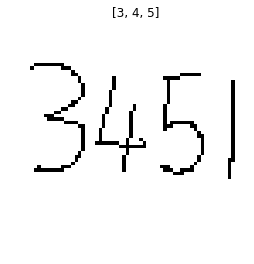

In [9]:
# simply testing it
test_img = cv2.imread("test.png")
ori_test = test_img.copy()
test_img = cv2.resize(test_img, (54, 54))
test_img = ms.preprocess(test_img)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

value = []
for pred in prediction:
    value.append(np.argmax(pred))
    
print(value[:value[-1]])

plt.imshow(cv2.cvtColor(ori_test, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(value[:value[-1]])
plt.show()

## Training the model on the training set

In [10]:
# initializa the generators

train_gen = Generator("hdf5/train.hdf5", BS, epochs, preprocessors)
val_gen = Generator("hdf5/val.hdf5", BS, epochs, preprocessors)

# callbacks, add in earlystopping
callbacks = [TensorBoard("logs", batch_size=BS, write_images=True),
            LearningRateScheduler(exp_decay),
            EarlyStopping(monitor="val_loss", min_delta=0.05, patience=20)]

In [11]:
# using back the same model

H = model.fit_generator(train_gen.generate(), validation_data=val_gen.generate(), steps_per_epoch=train_gen.n_img//BS,
                        validation_steps=val_gen.n_img//BS, epochs=epochs, callbacks=callbacks)

Epoch 1/200
  2/241 [..............................] - ETA: 23s - loss: 2.1440 - dense_3_loss: 0.5418 - dense_4_loss: 0.6514 - dense_5_loss: 0.4573 - dense_6_loss: 0.0724 - dense_7_loss: 3.9426e-04 - dense_8_loss: 0.4207 - dense_3_acc: 0.8359 - dense_4_acc: 0.8086 - dense_5_acc: 0.8945 - dense_6_acc: 0.9844 - dense_7_acc: 1.0000 - dense_8_acc: 0.8672

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


241/241 [==============================] - 17s 69ms/step - loss: 1.1980 - dense_3_loss: 0.3671 - dense_4_loss: 0.3843 - dense_5_loss: 0.2202 - dense_6_loss: 0.0628 - dense_7_loss: 0.0029 - dense_8_loss: 0.1607 - dense_3_acc: 0.8940 - dense_4_acc: 0.8924 - dense_5_acc: 0.9426 - dense_6_acc: 0.9841 - dense_7_acc: 0.9997 - dense_8_acc: 0.9490 - val_loss: 0.8145 - val_dense_3_loss: 0.2546 - val_dense_4_loss: 0.2527 - val_dense_5_loss: 0.1664 - val_dense_6_loss: 0.0354 - val_dense_7_loss: 0.0015 - val_dense_8_loss: 0.1039 - val_dense_3_acc: 0.9268 - val_dense_4_acc: 0.9309 - val_dense_5_acc: 0.9572 - val_dense_6_acc: 0.9897 - val_dense_7_acc: 0.9996 - val_dense_8_acc: 0.9667
Epoch 2/200
241/241 [==============================] - 17s 69ms/step - loss: 1.2613 - dense_3_loss: 0.3990 - dense_4_loss: 0.4146 - dense_5_loss: 0.2048 - dense_6_loss: 0.0527 - dense_7_loss: 0.0020 - dense_8_loss: 0.1882 - dense_3_acc: 0.9044 - dense_4_acc: 0.8979 - dense_5_acc: 0.9453 - dense_6_acc: 0.9862 - dense_7_a

Epoch 13/200
241/241 [==============================] - 16s 68ms/step - loss: 0.7302 - dense_3_loss: 0.2794 - dense_4_loss: 0.2275 - dense_5_loss: 0.1110 - dense_6_loss: 0.0265 - dense_7_loss: 5.2112e-04 - dense_8_loss: 0.0852 - dense_3_acc: 0.9325 - dense_4_acc: 0.9351 - dense_5_acc: 0.9652 - dense_6_acc: 0.9921 - dense_7_acc: 0.9998 - dense_8_acc: 0.9761 - val_loss: 0.8079 - val_dense_3_loss: 0.2866 - val_dense_4_loss: 0.2405 - val_dense_5_loss: 0.1544 - val_dense_6_loss: 0.0344 - val_dense_7_loss: 9.5975e-04 - val_dense_8_loss: 0.0911 - val_dense_3_acc: 0.9338 - val_dense_4_acc: 0.9347 - val_dense_5_acc: 0.9646 - val_dense_6_acc: 0.9928 - val_dense_7_acc: 0.9996 - val_dense_8_acc: 0.9739
Epoch 14/200
241/241 [==============================] - 16s 68ms/step - loss: 0.7498 - dense_3_loss: 0.2807 - dense_4_loss: 0.2377 - dense_5_loss: 0.1131 - dense_6_loss: 0.0250 - dense_7_loss: 4.7549e-04 - dense_8_loss: 0.0928 - dense_3_acc: 0.9302 - dense_4_acc: 0.9341 - dense_5_acc: 0.9661 - dense

Epoch 25/200
241/241 [==============================] - 16s 68ms/step - loss: 0.4550 - dense_3_loss: 0.1613 - dense_4_loss: 0.1518 - dense_5_loss: 0.0775 - dense_6_loss: 0.0181 - dense_7_loss: 4.9775e-04 - dense_8_loss: 0.0458 - dense_3_acc: 0.9500 - dense_4_acc: 0.9522 - dense_5_acc: 0.9758 - dense_6_acc: 0.9950 - dense_7_acc: 0.9999 - dense_8_acc: 0.9843 - val_loss: 0.7726 - val_dense_3_loss: 0.2527 - val_dense_4_loss: 0.2258 - val_dense_5_loss: 0.1596 - val_dense_6_loss: 0.0390 - val_dense_7_loss: 0.0014 - val_dense_8_loss: 0.0940 - val_dense_3_acc: 0.9444 - val_dense_4_acc: 0.9460 - val_dense_5_acc: 0.9629 - val_dense_6_acc: 0.9924 - val_dense_7_acc: 0.9996 - val_dense_8_acc: 0.9739
Epoch 26/200
241/241 [==============================] - 16s 68ms/step - loss: 0.4546 - dense_3_loss: 0.1660 - dense_4_loss: 0.1484 - dense_5_loss: 0.0783 - dense_6_loss: 0.0173 - dense_7_loss: 2.8113e-04 - dense_8_loss: 0.0444 - dense_3_acc: 0.9494 - dense_4_acc: 0.9538 - dense_5_acc: 0.9745 - dense_6_a

Epoch 37/200
241/241 [==============================] - 16s 68ms/step - loss: 0.3865 - dense_3_loss: 0.1461 - dense_4_loss: 0.1282 - dense_5_loss: 0.0637 - dense_6_loss: 0.0142 - dense_7_loss: 1.4181e-04 - dense_8_loss: 0.0342 - dense_3_acc: 0.9548 - dense_4_acc: 0.9592 - dense_5_acc: 0.9787 - dense_6_acc: 0.9958 - dense_7_acc: 0.9999 - dense_8_acc: 0.9876 - val_loss: 0.7097 - val_dense_3_loss: 0.2334 - val_dense_4_loss: 0.2319 - val_dense_5_loss: 0.1357 - val_dense_6_loss: 0.0265 - val_dense_7_loss: 0.0017 - val_dense_8_loss: 0.0805 - val_dense_3_acc: 0.9452 - val_dense_4_acc: 0.9448 - val_dense_5_acc: 0.9667 - val_dense_6_acc: 0.9928 - val_dense_7_acc: 0.9996 - val_dense_8_acc: 0.9777
Epoch 38/200
241/241 [==============================] - 16s 68ms/step - loss: 0.3868 - dense_3_loss: 0.1411 - dense_4_loss: 0.1281 - dense_5_loss: 0.0692 - dense_6_loss: 0.0120 - dense_7_loss: 4.1743e-04 - dense_8_loss: 0.0360 - dense_3_acc: 0.9554 - dense_4_acc: 0.9595 - dense_5_acc: 0.9781 - dense_6_a

In [12]:
model.save("svhn.h5")